# Book Recommendation menggunakan Collaborative Filtering

## Penyiapan Data

### Import Library

In [1]:
from google.colab import files
import os
import zipfile
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns
import scipy.sparse as sp


### Menyiapkan Kredensial Kaggle



In [2]:
# Upload kaggle.json

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}"'.format(
      name=fn))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json"


In [3]:
# Ubah permission file
!chmod 600 /content/kaggle.json

In [4]:
# Setup Kaggle environment
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

Informasi Dataset:

Jenis | Keterangan
--- | ---
Title | Book Recommendation Dataset
Source | [Kaggle](https://www.kaggle.com/arashnic/book-recommendation-dataset)
Maintainer | [Möbius](https://www.kaggle.com/arashnic)
License | [CC0: Public Domain](https://creativecommons.org/publicdomain/zero/1.0/)
Usability | 10.0

In [5]:
# Download Dataset
!kaggle datasets download -d arashnic/book-recommendation-dataset

Dataset URL: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset
License(s): CC0-1.0
  0% 0.00/24.3M [00:00<?, ?B/s]
100% 24.3M/24.3M [00:00<00:00, 2.02GB/s]


In [6]:
# melakukan ekstraksi pada file zip
local_zip = 'book-recommendation-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/book-recommendation-dataset/')
zip_ref.close()

In [7]:
# Menghapus berkas zip yang sudah tidak diperlukan
!rm book-recommendation-dataset.zip

## Data Understanding

Dataset ini terdiri dari tiga berkas CSV, yaitu ```Books.csv```, ```Ratings.csv```, dan ```Users.csv```.
Langkah selanjutnya, kita akan membuka masing-masing berkas tersebut menggunakan bantuan pustaka ```pandas``` untuk melihat isi datanya.

In [8]:
# Load dataset
books = pd.read_csv('book-recommendation-dataset/Books.csv')
ratings = pd.read_csv('book-recommendation-dataset/Ratings.csv')
users = pd.read_csv('book-recommendation-dataset/Users.csv')

<ipython-input-8-4deec0a0fcf7>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('book-recommendation-dataset/Books.csv')


### Books

Berikut ini adalah isi dari `Books.csv`

In [9]:
books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


In [10]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


Dari keluaran di atas dapat diketahui bahwa berkas `Books.csv` memuat data-data buku yang terdiri dari 271360 baris dan memiliki 8 kolom, diantaranya adalah :  

- `ISBN` : berisi kode ISBN dari buku  
- `Book-Title` : berisi judul buku
- `Book-Author` : berisi penulis buku
- `Year-Of-Publication` : tahun terbit buku  
- `Publisher` : penerbit buku  
- `Image-URL-S` : URL menuju gambar buku berukuran kecil
- `Image-URL-M` : URL menuju gambar buku berukuran sedang
- `Image-URL-L` : URL menuju gambar buku berukuran besar

### Ratings

Berikut ini adalah isi dari berkas `Ratings.csv`

In [11]:
ratings

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [12]:
ratings.groupby('Book-Rating').count()

,User-ID,ISBN
Book-Rating,,
0,716109,716109
1,1770,1770
2,2759,2759
3,5996,5996
4,8904,8904
5,50974,50974
6,36924,36924
7,76457,76457
8,103736,103736


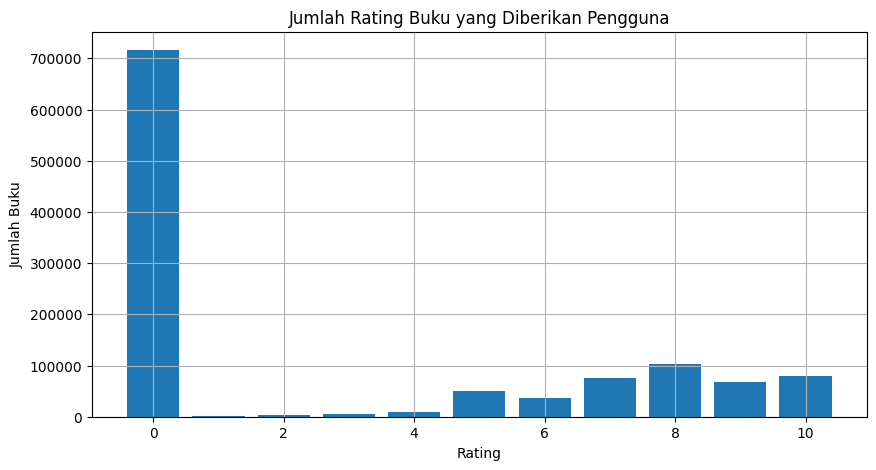

In [13]:
rating_counter = ratings.groupby('Book-Rating').count()
plt.figure(figsize=(10,5))
plt.title('Jumlah Rating Buku yang Diberikan Pengguna')
plt.xlabel('Rating')
plt.ylabel('Jumlah Buku')
plt.bar(rating_counter.index, rating_counter['ISBN'])
plt.grid(True)
plt.show()

Pada visualisasi data di atas dapat diketahui bahwa data tidak seimbang dan banyak pengguna yang memberikan rating 0.

In [14]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [15]:
ratings.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,User-ID,Book-Rating
count,1149780.000000,1149780.000000
mean,140386.395126,2.866950
std,80562.277718,3.854184
min,2.000000,0.000000
25%,70345.000000,0.000000
50%,141010.000000,0.000000
75%,211028.000000,7.000000
max,278854.000000,10.000000


Berdasarkan hasil di atas, dapat disimpulkan bahwa berkas ```Ratings.csv``` berisi data penilaian buku dari para pengguna. Dataset ini terdiri dari 1.149.780 baris dan memiliki 3 kolom, yaitu:  
 - `User-ID` : menyimpan ID unik pengguna
 - `ISBN` : berisi kode ISBN buku yang dinilai oleh pengguna
 - `Book-Rating` : berisi nilai rating yang diberikan oleh pengguna berkisar antara 0-10

### Users

Berikut ini adalah isi dari `Users.csv`

In [16]:
users

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


In [17]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [18]:
users.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


Dari hasil di atas dapat diketahui bahwa berkas `Users.csv` memuat data pengguna. Data ini terdiri dari 278858 baris dan memiliki 3 kolom, yaitu :

- `User-ID` : berisi ID unik pengguna
- `Location` : berisi data lokasi pengguna
- `Age` : berisi data usia pengguna

### EDA Univariatae

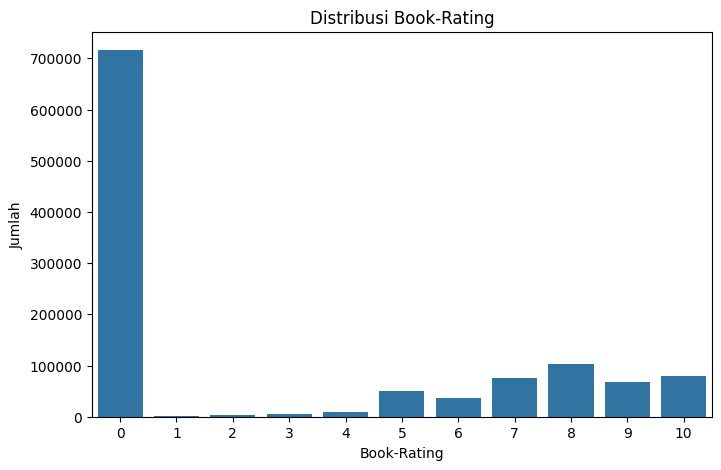

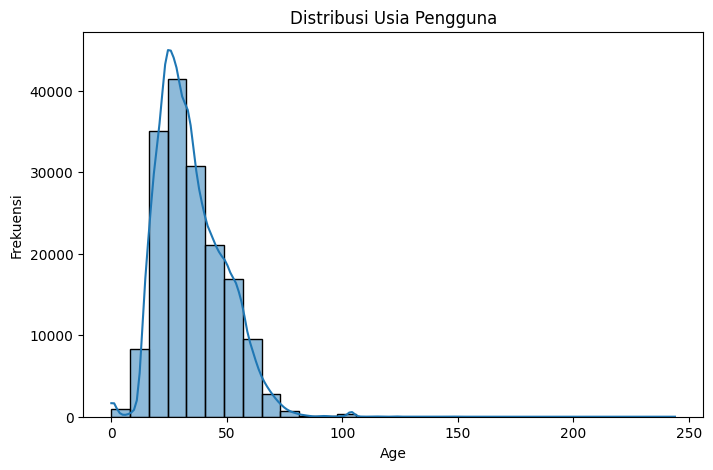

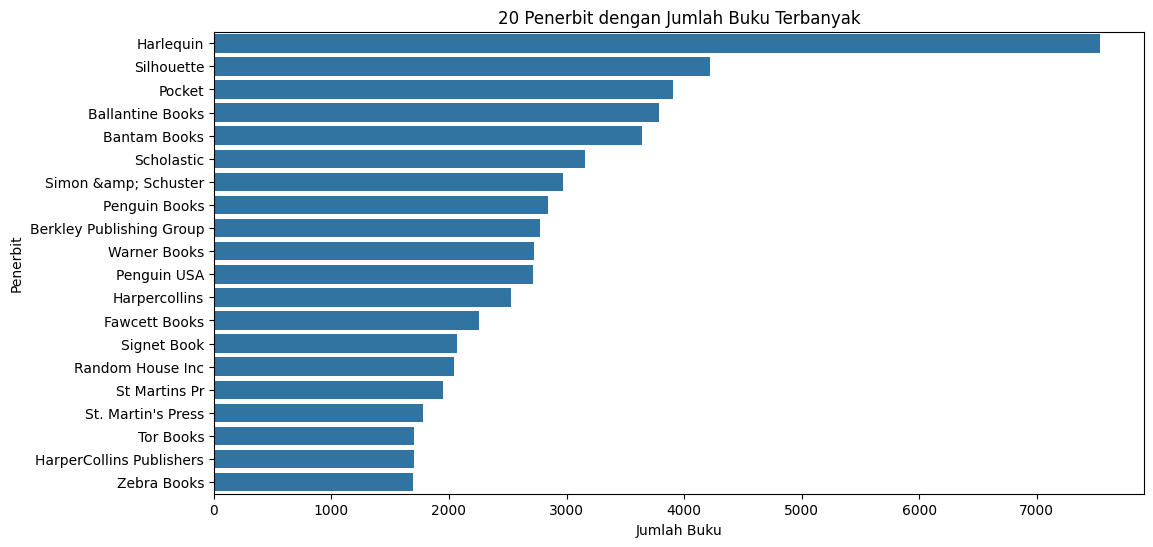

In [19]:
# Distribusi rating buku
plt.figure(figsize=(8,5))
sns.countplot(x='Book-Rating', data=ratings)
plt.title('Distribusi Book-Rating')
plt.xlabel('Book-Rating')
plt.ylabel('Jumlah')
plt.show()

# Distribusi usia pengguna
plt.figure(figsize=(8,5))
sns.histplot(users['Age'], bins=30, kde=True)
plt.title('Distribusi Usia Pengguna')
plt.xlabel('Age')
plt.ylabel('Frekuensi')
plt.show()

# 3. Distribusi penerbit terbanyak (top 20)
top_publishers = books['Publisher'].value_counts().head(20)
plt.figure(figsize=(12,6))
sns.barplot(x=top_publishers.values, y=top_publishers.index)
plt.title('20 Penerbit dengan Jumlah Buku Terbanyak')
plt.xlabel('Jumlah Buku')
plt.ylabel('Penerbit')
plt.show()




- Book-Rating: Data rating tidak seimbang di rating (0). Jika di nilai dari rating (1-10) mayoritas pengguna memberi rating tinggi (6–10), menunjukkan kepuasan tinggi terhadap buku.

- Usia Pengguna: Didominasi oleh usia 20–40 tahun; terdapat outlier hingga usia 250. Tapi fitur ini nantinya tidak digunakan dalam training model.

- Penerbit Buku: Harlequin paling produktif, diikuti Silhouette dan Pocket — dominasi penerbit besar terlihat jelas.

### EDA Multivariate

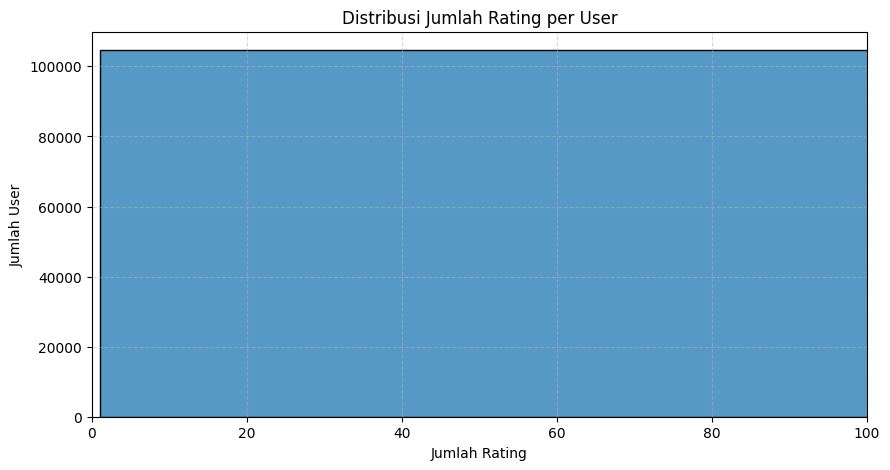

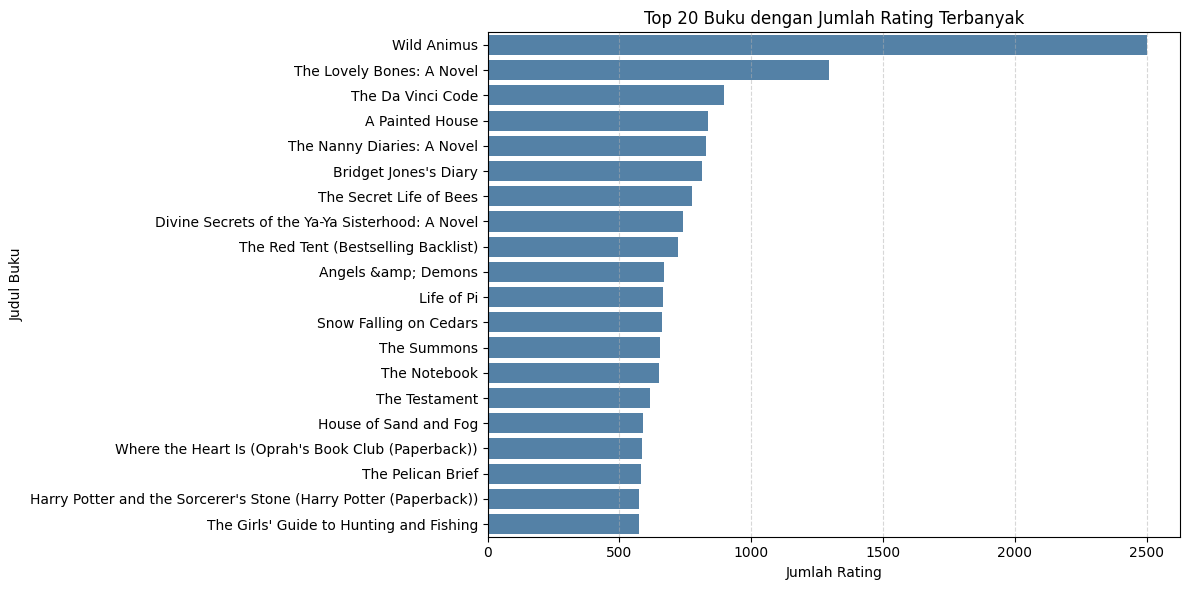

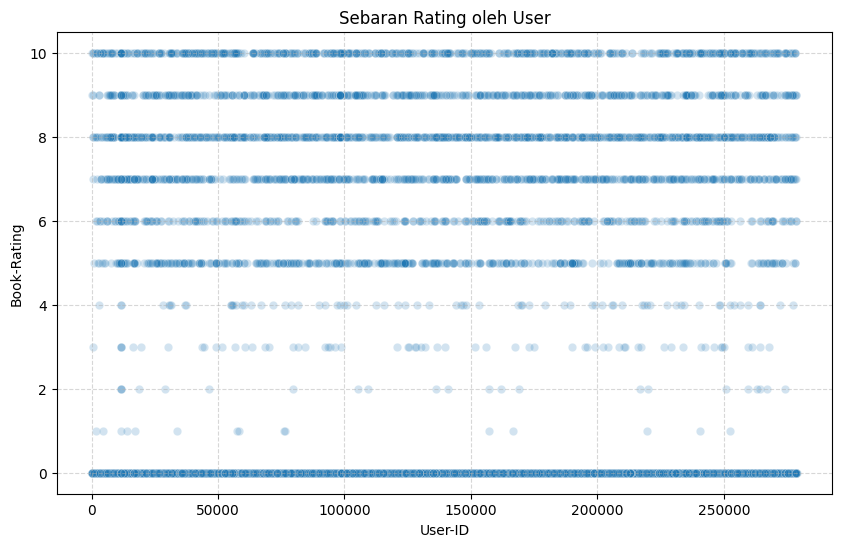

In [20]:
# 1. Distribusi Jumlah Rating per User
user_rating_counts = ratings['User-ID'].value_counts()

plt.figure(figsize=(10, 5))
sns.histplot(user_rating_counts, bins=50, kde=False)
plt.title('Distribusi Jumlah Rating per User')
plt.xlabel('Jumlah Rating')
plt.ylabel('Jumlah User')
plt.xlim(0, 100)  # Batasi untuk visualisasi
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 2. Top 20 Buku dengan Jumlah Rating Terbanyak (berdasarkan judul)
ratings_with_titles = ratings.merge(books[['ISBN', 'Book-Title']], on='ISBN', how='left')
top_books_title = ratings_with_titles['Book-Title'].value_counts().head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_books_title.values, y=top_books_title.index, color='steelblue')
plt.title('Top 20 Buku dengan Jumlah Rating Terbanyak')
plt.xlabel('Jumlah Rating')
plt.ylabel('Judul Buku')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 3. Scatter Plot: User-ID vs Book-Rating (Sample)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='User-ID', y='Book-Rating', data=ratings.sample(10000), alpha=0.2)
plt.title('Sebaran Rating oleh User')
plt.xlabel('User-ID')
plt.ylabel('Book-Rating')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()




Berdasarkan visualisasi data, dapat disimpulkan bahwa mayoritas pengguna hanya memberikan sedikit rating, menunjukkan tingkat partisipasi yang rendah. Buku yang paling banyak diberi rating adalah Wild Animus, mengindikasikan popularitas atau promosi besar-besaran terhadap buku tersebut. Selain itu, distribusi rating cenderung tinggi (nilai 8–10), yang menunjukkan adanya bias positif dari pengguna dalam memberikan penilaian.

## Data Preparation

Sebelum melakukan pemodelan, data perlu melewati proses persiapan terlebih dahulu. Berikut adalah langkah-langkah yang dilakukan dalam tahap persiapan data.

### Handling Imbalanced Data

Karena sebelumnya diketahui bahwa data rating tidak seimbang, pada tahap ini saya melakukan penghapusan data dengan rating 0.

In [21]:
ratings.drop(ratings[ratings["Book-Rating"] == 0].index, inplace=True)

Berikut ini adalah jumlah data setelah di-drop

In [22]:
ratings.shape

(433671, 3)

In [23]:
ratings

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6
...,...,...,...
1149773,276704,0806917695,5
1149775,276704,1563526298,9
1149777,276709,0515107662,10
1149778,276721,0590442449,10


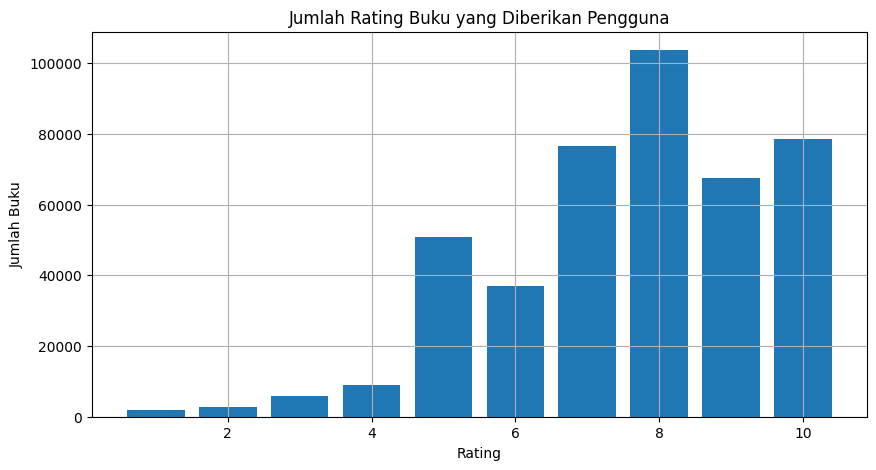

In [24]:
rating_counter = ratings.groupby('Book-Rating').count()
plt.figure(figsize=(10,5))
plt.title('Jumlah Rating Buku yang Diberikan Pengguna')
plt.xlabel('Rating')
plt.ylabel('Jumlah Buku')
plt.bar(rating_counter.index, rating_counter['ISBN'])
plt.grid(True)
plt.show()

### Encoding Data

Proses encoding dilakukan untuk mengonversi ``User-ID`` dan ``ISBN`` menjadi indeks berbentuk bilangan bulat (integer).

In [25]:
# Mengubah User-ID menjadi list unik tanpa duplikasi
user_ids = ratings['User-ID'].unique().tolist()

# Melakukan encoding User-ID ke angka (integer)
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}

# Membuat mapping kebalikan dari angka ke User-ID asli
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

In [26]:
# Mengubah ISBN menjadi list tanpa nilai yang sama
isbn_list = ratings['ISBN'].unique().tolist()

# Melakukan encoding ISBN
isbn_to_isbn_encoded = {x: i for i, x in enumerate(isbn_list)}

# Melakukan proses encoding angka ke ISBN
isbn_encoded_to_isbn = {i: x for i, x in enumerate(isbn_list)}

Setelah encoding selesai, hasilnya dimapping ke dataframe ``ratings``

In [27]:
# Mapping User-ID ke kolom 'user' dengan indeks encoded
ratings['user'] = ratings['User-ID'].map(user_to_user_encoded)

In [28]:
# Mapping ISBN ke kolom 'book' dengan indeks encoded
ratings['book'] = ratings['ISBN'].map(isbn_to_isbn_encoded)

In [29]:
ratings

,User-ID,ISBN,Book-Rating,user,book
1,276726,0155061224,5,0,0
3,276729,052165615X,3,1,1
4,276729,0521795028,6,1,2
6,276736,3257224281,8,2,3
7,276737,0600570967,6,3,4
...,...,...,...,...,...
1149773,276704,0806917695,5,77801,185971
1149775,276704,1563526298,9,77801,121200
1149777,276709,0515107662,10,77802,23986
1149778,276721,0590442449,10,77803,151038


In [30]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 433671 entries, 1 to 1149779
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      433671 non-null  int64 
 1   ISBN         433671 non-null  object
 2   Book-Rating  433671 non-null  int64 
 3   user         433671 non-null  int64 
 4   book         433671 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 19.9+ MB


### Randomize Dataset

Proses ini dilakukan untuk mengacak urutan data sehingga distribusi datanya menjadi acak dan tidak berurutan. Tujuannya adalah agar model yang dibangun tidak terpengaruh oleh pola urutan data asli, sehingga hasil pelatihan menjadi lebih representatif dan mengurangi risiko bias akibat urutan data.


In [31]:
# Mengacak dataset
df = ratings.sample(frac=1, random_state=42)
df

,User-ID,ISBN,Book-Rating,user,book
144846,32440,0380018179,8,9713,1013
211411,49144,8422641127,5,14390,54663
647520,156424,3442453844,7,44370,127953
30124,7125,0060586125,8,2587,10359
1052982,251606,0316789844,8,70897,7053
...,...,...,...,...,...
658592,159834,0441132456,7,45235,70428
958724,231613,0747542333,5,65186,33018
335707,79923,0440206154,8,22993,6822
373697,89610,8880891960,5,25753,84887


### Data Standardization and Splitting

Setelah data diacak, dataset kemudian dibagi menjadi dua bagian, yaitu data pelatihan sebanyak 80% dan data validasi sebanyak 20%.

Selain itu, nilai rating yang awalnya berada pada rentang 0 hingga 10 distandarisasi menjadi rentang 0 hingga 1 untuk mempermudah dan meningkatkan efisiensi proses pelatihan model.


In [32]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah resto
num_isbn = len(isbn_encoded_to_isbn)
print(num_isbn)

# Mengubah rating menjadi nilai float
df['Book-Rating'] = df['Book-Rating'].values.astype(np.float32)

# Nilai minimum Book-Rating
min_rating = min(df['Book-Rating'])

# Nilai maksimal Book-Rating
max_rating = max(df['Book-Rating'])

print('Number of User: {}, Number of ISBN: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_isbn, min_rating, max_rating
))

77805
185973
Number of User: 77805, Number of ISBN: 185973, Min Rating: 1.0, Max Rating: 10.0


In [33]:
# Membuat variabel x untuk mencocokkan data user dan book menjadi satu value
x = df[['user', 'book']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['Book-Rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[  9713   1013]
 [ 14390  54663]
 [ 44370 127953]
 ...
 [ 22993   6822]
 [ 25753  84887]
 [ 21414  43793]] [0.77777778 0.44444444 0.66666667 ... 0.77777778 0.44444444 0.77777778]


## Modelling

### Membuat Kelas RecommenderNet

Membangun model rekomendasi berbasis matrix factorization (faktorisasi matriks) menggunakan embedding untuk user dan item (dalam hal ini, ISBN buku), mirip dengan pendekatan pada model-model seperti Collaborative Filtering.

In [34]:
# Definisi model rekomendasi
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_isbn, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_isbn = num_isbn
        self.embedding_size = embedding_size

        self.user_embedding = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)

        self.isbn_embedding = layers.Embedding(
            input_dim=num_isbn,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.isbn_bias = layers.Embedding(num_isbn, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        isbn_vector = self.isbn_embedding(inputs[:, 1])
        isbn_bias = self.isbn_bias(inputs[:, 1])

        dot_user_isbn = tf.reduce_sum(user_vector * isbn_vector, axis=1, keepdims=True)
        x = dot_user_isbn + user_bias + isbn_bias

        return tf.nn.sigmoid(x)


- Struktur Kode & Penjelasan
  - `class RecommenderNet(tf.keras.Model)`: Mendefinisikan kelas model kustom turunan dari tf.keras.Model.
  - `def __init__(self, num_users, num_isbn, embedding_size, **kwargs)`: Konstruktor untuk menginisialisasi parameter dan layer.

  - `super(RecommenderNet, self).__init__(**kwargs)`
Memanggil konstruktor dari kelas induk `(tf.keras.Model)`.

  - `self.user_embedding = layers.Embedding`(...)
Layer embedding untuk merepresentasikan setiap user dalam bentuk vektor berdimensi embedding_size.

  - `self.user_bias = layers.Embedding(num_users, 1)`
Embedding 1-dimensi untuk menyimpan bias per user (semacam preferensi umum user terhadap rating).

  - `self.isbn_embedding = layers.Embedding(...)`
Layer embedding untuk merepresentasikan setiap buku (berdasarkan ISBN).

  - `self.isbn_bias = layers.Embedding(num_isbn, 1)`
Bias per buku menangkap apakah sebuah buku secara umum cenderung mendapat rating tinggi atau rendah.

  - `user_vector = self.user_embedding(inputs[:, 0])` , `user_bias = self.user_bias(inputs[:, 0])` , `isbn_vector = self.isbn_embedding(inputs[:, 1])` , `isbn_bias = self.isbn_bias(inputs[:, 1])` :
Mengambil embedding dan bias untuk user dan ISBN dari input.

  - `dot_user_isbn = tf.reduce_sum(user_vector * isbn_vector, axis=1, keepdims=True)`: Menghitung dot product antara embedding user dan buku — nilai ini mencerminkan tingkat kesesuaian user terhadap buku tersebut.

  - `x = dot_user_isbn + user_bias + isbn_bias` : Menambahkan bias user dan bias ISBN ke hasil dot product.

  - `return tf.nn.sigmoid(x)` : Menggunakan sigmoid untuk menormalkan output ke rentang 0–1 — cocok untuk prediksi rating terstandarisasi (misal 0–1), atau bisa disesuaikan nanti ke skala 1–10.

### Melatih Model

In [40]:
best_model = RecommenderNet(num_users=num_users, num_isbn=num_isbn, embedding_size=12)

best_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

history = best_model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=200,
    validation_data=(x_val, y_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_root_mean_squared_error',
            patience=3,
            restore_best_weights=True
        )
    ]
)


Epoch 1/20
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - loss: 0.0879 - root_mean_squared_error: 0.2963 - val_loss: 0.0686 - val_root_mean_squared_error: 0.2612
Epoch 2/20
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 38s 18ms/step - loss: 0.0626 - root_mean_squared_error: 0.2488 - val_loss: 0.0563 - val_root_mean_squared_error: 0.2349
Epoch 3/20
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - loss: 0.0498 - root_mean_squared_error: 0.2202 - val_loss: 0.0500 - val_root_mean_squared_error: 0.2208
Epoch 4/20
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - loss: 0.0422 - root_mean_squared_error: 0.2024 - val_loss: 0.0460 - val_root_mean_squared_error: 0.2121
Epoch 5/20
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - loss: 0.0368 - root_mean_squared_error: 0.1893 - val_loss: 0.0432 - val_root_mean_squared_error: 0.2061
Epoch 6/20
1735/1735 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - loss: 0.0330 - root_mean_squared_error: 0.1798 - val_loss: 0.0413 - val_root_mean_squared_error: 0.2019
Epoch 7/20
1735/1735 ━━━━━━━

Model berhenti dilatih pada epoch ke-19 karena tidak ada peningkatan signifikan pada metrik validasi selama beberapa epoch terakhir. Dengan nilai :

- RMSE : 0.1288
-val-loss: 0.378
-val_RMSE : 0.1929

## Evaluasi

In [41]:
loss, rmse = best_model.evaluate(x_val, y_val)
print(f"Validation RMSE: {rmse}")


2711/2711 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0375 - root_mean_squared_error: 0.1921
Validation RMSE: 0.19252102077007294


Nilai RMSE yang dicapai pada data validasi sebesar 0.1925, menunjukkan bahwa prediksi model terhadap rating cukup akurat dan stabil.

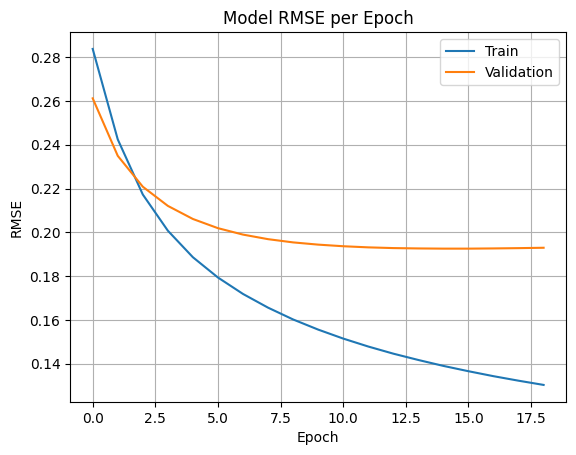

In [42]:
# Visualisasi metrik
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model RMSE per Epoch')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

Model menunjukkan peningkatan performa selama pelatihan, ditandai dengan:

- RMSE pada data training terus menurun secara konsisten.

- RMSE pada data validasi menurun di awal dan stabil mendekati 0.19, tanpa overfitting yang jelas.

Artinya, model belajar dengan baik dan generalisasi cukup baik terhadap data yang belum pernah dilihat. Model berhenti secara otomatis di epoch ke-19 karena tidak ada peningkatan signifikan, sesuai pengaturan EarlyStopping.

## Mendapatkan Rekomendasi

In [43]:
books_data = books  # Alias supaya beda dari nama awal
ratings_data = pd.read_csv('book-recommendation-dataset/Ratings.csv')

# Ambil 1 user secara acak
chosen_user_id = ratings_data['User-ID'].sample(1).iloc[0]
user_ratings = ratings_data[ratings_data['User-ID'] == chosen_user_id]

# Buku yang belum dibaca user tersebut
unread_isbns = books_data[~books_data['ISBN'].isin(user_ratings['ISBN'])]['ISBN']
unread_encoded = [isbn_to_isbn_encoded[isbn] for isbn in unread_isbns if isbn in isbn_to_isbn_encoded]

# Buat array input untuk prediksi
encoded_user_id = user_to_user_encoded[chosen_user_id]
prediction_input = np.hstack(
    ([[encoded_user_id]] * len(unread_encoded), np.array(unread_encoded).reshape(-1, 1))
)

In [44]:
# Prediksi rating dari model
predicted_scores = best_model.predict(prediction_input).flatten()
top_indices = predicted_scores.argsort()[-10:][::-1]

recommended_isbns = [isbn_encoded_to_isbn[unread_encoded[i]] for i in top_indices]

# Tampilkan hasil
print(f"Rekomendasi untuk User ID: {chosen_user_id}")
print("=" * 30)

print("\nBuku dengan rating tertinggi dari user:")
print("-" * 40)
top_user_books = user_ratings.sort_values(by='Book-Rating', ascending=False).head(5)['ISBN']
top_books_info = books_data[books_data['ISBN'].isin(top_user_books)]

for _, row in top_books_info.iterrows():
    print(f"{row['Book-Title']} - {row['Book-Author']}")

print("\nRekomendasi Buku Terbaik untuk User Ini:")
print("-" * 40)
recommended_info = books_data[books_data['ISBN'].isin(recommended_isbns)]

for _, row in recommended_info.iterrows():
    print(f"{row['Book-Title']} - {row['Book-Author']}")

4676/4676 ━━━━━━━━━━━━━━━━━━━━ 3s 689us/step
Rekomendasi untuk User ID: 129008

Buku dengan rating tertinggi dari user:
----------------------------------------
The Slippery Slope (A Series of Unfortunate Events, Book 10) - Lemony Snicket
The Honk and Holler Opening Soon - Billie Letts
The Iron Tonic: Or, A Winter Afternoon in Lonely Valley - Edward Gorey
The Day Jimmy's Boa Ate the Wash - Trinka Hakes Noble
Cypress Grove - James Sallis

Rekomendasi Buku Terbaik untuk User Ini:
----------------------------------------
Lonesome Dove - Larry McMurtry
The Return of the King (The Lord of the Rings, Part 3) - J.R.R. TOLKIEN
Harry Potter and the Sorcerer's Stone (Book 1) - J. K. Rowling
The Two Towers (The Lord of the Rings, Part 2) - J. R. R. Tolkien
The Giving Tree - Shel Silverstein
Calvin and Hobbes - Bill Watterson
52 Deck Series: 52 Ways to Celebrate Friendship - Lynn Gordon
My Sister's Keeper : A Novel (Picoult, Jodi) - Jodi Picoult
Dilbert: A Book of Postcards - Scott Adams
Harry Pot

### **Kesimpulan**

Model sistem rekomendasi buku berbasis deep learning berhasil dikembangkan dan diimplementasikan menggunakan data interaksi pengguna dan buku. Berdasarkan hasil evaluasi dan pengujian, model mampu memberikan rekomendasi yang relevan secara personal bagi pengguna, termasuk menampilkan daftar buku yang belum pernah dibaca namun diprediksi akan disukai.

Model ini telah menunjukkan performa yang baik dengan nilai evaluasi RMSE yang cukup rendah, menandakan akurasi prediksi yang tinggi. Rekomendasi yang dihasilkan juga menunjukkan konsistensi terhadap preferensi pengguna berdasarkan histori rating sebelumnya.

Sistem yang telah dikembangkan ini memiliki potensi besar untuk diimplementasikan lebih lanjut sebagai **aplikasi nyata** dalam platform digital, seperti toko buku online atau aplikasi perpustakaan.

Meski demikian, **pengembangan lanjutan masih diperlukan**, seperti:

* Integrasi fitur tambahan (misalnya genre, sinopsis, metadata buku),
* Penggabungan pendekatan hybrid (content-based + collaborative),
* Evaluasi berbasis umpan balik pengguna nyata (user feedback).

Dengan penyempurnaan tersebut, sistem ini dapat menjadi solusi rekomendasi yang lebih komprehensif dan adaptif terhadap kebutuhan pengguna.

---